## 8.1 의도 탐지 예제

In [1]:
!pip install optuna

In [2]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

## 8.2 벤치마크 클래스 만들기

In [4]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # 나중에 정의합니다
        pass    

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")  # "plus" 범위 박의 훈련 샘플이 담긴 서브셋을 의미

Found cached dataset clinc_oos (/Users/daniellee/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [8]:
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

/var/folders/x8/rtsz9nj93kdd9vy3_52zngfc0000gn/T/ipykernel_10254/1330793347.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


In [9]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [11]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [13]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 42.810
레이턴시 (ms) - 37.233
레이턴시 (ms) - 48.231


In [14]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 35.78 +\- 0.79
테스트 세트 정확도 - 0.867


In [16]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [18]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Loading cached processed dataset at /Users/daniellee/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-fea0c49e7fa93460.arrow
Loading cached processed dataset at /Users/daniellee/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-7fecf478efcd7d09.arrow
Loading cached processed dataset at /Users/daniellee/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-5bc73521e2f625e6.arrow


In [19]:
from huggingface_hub import notebook_login

# notebook_login()
# jupyter notebook에서 안될때는 jupyter-lab이 실행중인 경로에서 "huggingface-cli login" 실행

In [20]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [21]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=True)

In [22]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
# 트랜스포머 4.23.0 버전부터 로깅 수준을 문자열로 지정해야 합니다.
# student_training_args.log_level = 40
student_training_args.log_level = 'error'

In [23]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [24]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [25]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [26]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [27]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [28]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/Users/daniellee/Develop/study_huggingface/ch8_model_compression/distilbert-base-uncased-finetuned-clinc is already a clone of https://huggingface.co/hexists/distilbert-base-uncased-finetuned-clinc. Make sure you pull the latest changes with `repo.git_pull()`.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.283800,3.278687,0.745484
2,2.622000,1.870629,0.833226
3,1.546600,1.162256,0.893871
4,1.013500,0.861896,0.910000
5,0.798500,0.778602,0.915806


TrainOutput(global_step=1590, training_loss=2.0490037549216793, metrics={'train_runtime': 2022.314, 'train_samples_per_second': 37.704, 'train_steps_per_second': 0.786, 'total_flos': 413896353421488.0, 'train_loss': 2.0490037549216793, 'epoch': 5.0})

In [29]:
distilbert_trainer.push_to_hub("Training completed!")

Upload file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

To https://huggingface.co/hexists/distilbert-base-uncased-finetuned-clinc
   b39e8d7..eb4eaa5  main -> main



'https://huggingface.co/hexists/distilbert-base-uncased-finetuned-clinc/commit/eb4eaa5f9506f5ecaa438d71e25ba618424ae3a1'

In [30]:
finetuned_ckpt = "hexists/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [31]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 18.15 +\- 1.07
테스트 세트 정확도 - 0.859


/var/folders/x8/rtsz9nj93kdd9vy3_52zngfc0000gn/T/ipykernel_10254/1811107928.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


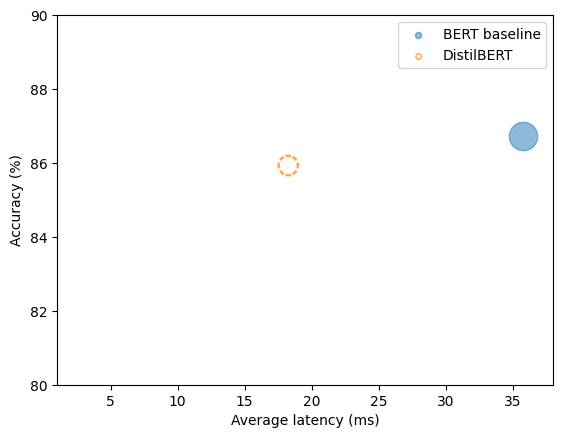

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

In [33]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
import optuna 

best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

print(best_run)

[I 2023-06-26 22:15:16,195] A new study created in memory with name: no-name-00bfbdda-5c26-4570-ab99-1580d0e8ec6c
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.402100,0.204262,0.606452
2,0.170500,0.099008,0.841290
3,0.104600,0.065601,0.883548
4,0.078300,0.048857,0.904516
5,0.064200,0.040580,0.916452
6,0.056200,0.035782,0.917742
7,0.051100,0.032858,0.920000
8,0.048100,0.031257,0.922258
9,0.046600,0.030826,0.920323


[I 2023-06-26 23:10:10,813] Trial 0 finished with value: 0.9203225806451613 and parameters: {'num_train_epochs': 9, 'alpha': 0.74436928980191, 'temperature': 10}. Best is trial 0 with value: 0.9203225806451613.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.386600,0.195369,0.599677
2,0.163300,0.095150,0.841613
3,0.100500,0.063323,0.883226
4,0.075200,0.047140,0.902581
5,0.061500,0.039090,0.915161
6,0.053600,0.034227,0.918387
7,0.048300,0.031051,0.921613
8,0.045100,0.029201,0.922903
9,0.043100,0.028202,0.925161
10,0.042000,0.027788,0.922581


[I 2023-06-27 00:11:50,380] Trial 1 finished with value: 0.9225806451612903 and parameters: {'num_train_epochs': 10, 'alpha': 0.49237209362866596, 'temperature': 15}. Best is trial 1 with value: 0.9225806451612903.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.425500,0.219138,0.610645
2,0.183100,0.106700,0.835161
3,0.113000,0.071260,0.882581
4,0.085600,0.054085,0.903226
5,0.071600,0.046066,0.910645
6,0.064400,0.042112,0.914516
7,0.060500,0.040872,0.914516


[I 2023-06-27 00:54:39,944] Trial 2 finished with value: 0.9145161290322581 and parameters: {'num_train_epochs': 7, 'alpha': 0.432253135586808, 'temperature': 7}. Best is trial 1 with value: 0.9225806451612903.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.386000,0.196931,0.590968
2,0.165400,0.097680,0.834194
3,0.103400,0.066189,0.881935
4,0.078700,0.050378,0.899677
5,0.065500,0.042566,0.911290
6,0.058200,0.038159,0.916452
7,0.053700,0.035875,0.916774
8,0.051600,0.035047,0.916129


[I 2023-06-27 01:43:27,185] Trial 3 finished with value: 0.9161290322580645 and parameters: {'num_train_epochs': 8, 'alpha': 0.2847321259070802, 'temperature': 16}. Best is trial 1 with value: 0.9225806451612903.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.383100,0.195379,0.589355
2,0.164200,0.097191,0.832581
3,0.102900,0.066055,0.880323
4,0.078400,0.050335,0.900000
5,0.065300,0.042571,0.911290
6,0.058000,0.038180,0.916129
7,0.053500,0.035902,0.916774
8,0.051400,0.035073,0.916129


[I 2023-06-27 02:32:21,399] Trial 4 finished with value: 0.9161290322580645 and parameters: {'num_train_epochs': 8, 'alpha': 0.9341531662586628, 'temperature': 18}. Best is trial 1 with value: 0.9225806451612903.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.458500,0.233160,0.629032
2,0.191900,0.107079,0.843548
3,0.113000,0.067892,0.890645
4,0.082200,0.049073,0.907097
5,0.066400,0.040230,0.915806
6,0.057700,0.035294,0.918387
7,0.052200,0.032353,0.921290
8,0.049200,0.030748,0.923226
9,0.047600,0.030339,0.923871


[I 2023-06-27 03:27:06,204] Trial 5 finished with value: 0.9238709677419354 and parameters: {'num_train_epochs': 9, 'alpha': 0.47251658607696045, 'temperature': 5}. Best is trial 5 with value: 0.9238709677419354.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.415900,0.214003,0.605161
2,0.179300,0.105109,0.834839


[I 2023-06-27 03:39:16,404] Trial 6 pruned. 
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.394400,0.200210,0.600323


[I 2023-06-27 03:45:23,668] Trial 7 pruned. 
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.494400,0.250210,0.642581
2,0.203300,0.109717,0.847419
3,0.115400,0.066962,0.895484
4,0.081800,0.047292,0.908710
5,0.065100,0.038424,0.919032
6,0.056000,0.033505,0.921613
7,0.050200,0.030361,0.927097
8,0.046800,0.028561,0.927742
9,0.044700,0.027679,0.929032
10,0.043600,0.027288,0.928387


[I 2023-06-27 04:46:30,998] Trial 8 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.3781776765475281, 'temperature': 4}. Best is trial 8 with value: 0.9283870967741935.
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.458500,0.233160,0.629032
2,0.191900,0.107079,0.843548
3,0.113000,0.067892,0.890645
4,0.082200,0.049073,0.907097
5,0.066400,0.040230,0.915806
6,0.057700,0.035294,0.918387
7,0.052200,0.032353,0.921290
8,0.049200,0.030748,0.923226
9,0.047600,0.030339,0.923871


[I 2023-06-27 05:41:19,432] Trial 9 pruned. 
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.805200,0.422160,0.655484
2,0.329300,0.162847,0.830000


[I 2023-06-27 05:53:28,665] Trial 10 pruned. 
/Users/daniellee/Develop/study_huggingface/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.798400,0.405471,0.664839
2,0.307200,0.140670,0.846774
3,0.140900,0.072805,0.900968


In [ ]:
print(best_run)

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train()

In [ ]:
distil_trainer.push_to_hub("Training complete")

In [ ]:
# `hexists`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "hexists/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

### 8.4 양자화로 모델 속도 높이기

In [ ]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

(weights / scale + zero_point).clamp(-128, 127).round().char()

from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

In [ ]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [ ]:
%%timeit 
weights @ weights

In [ ]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

In [ ]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

In [ ]:
from torch.quantization import quantize_dynamic

# `hexists`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "hexists/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

In [ ]:
torch.backends.quantized.engine = 'qnnpack'  # 실행이 안될때는 이렇게... https://stackoverflow.com/a/69996449
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 8.5 양자화된 모델의 벤치마크 수행하기

In [ ]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

### 8.6 ONNX와 ONNX 런타임으로 추론 최적화하기

In [ ]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"  # ONNX 런타입에서 병렬 계산에 사용할 스레드 개수
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"  # 대기 스레드를 활성 상태로 지정

In [ ]:
from transformers.convert_graph_to_onnx import convert

# `hexists`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "hexists/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")
#opset=12, ONNX는 변경 불가능한 연산 규격을 그룹화하기 위해 연산자 집합을 사용, ONNX 라이브러리의 특정 버전

In [ ]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_model = create_model_for_provider(onnx_model_path)

In [ ]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

np.argmax(logits_onnx)
clinc_enc["test"][0]["labels"] # 정답 레이블

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

plot_metrics(perf_metrics, optim_type)